In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib import image
import os

In [2]:
# loading 240 images for training & 160 for testing
train_images = []
test_images = []
for i in range(1,41):
    j = 1
    arr = os.listdir('s'+str(i)+'/')
    for img in arr:
        if(j <= 6):
            train_images.append((image.imread('s'+str(i)+'/'+img)).flatten())
        else:
            test_images.append((image.imread('s'+str(i)+'/'+img)).flatten())
        j+=1

In [3]:
def mean_faces(X):
    mn,p = X.shape
    M = np.zeros((mn,1))
    for i in range(mn):
        for j in range(p):
            M[i] += X[i][j]
        M[i] /= p
    return M

In [4]:
def s_cov(X): 
    # Surrogate cov
    r,c = X.shape 
    cov = np.zeros((c,c))
    # Covariances        
    for z in range(c):
        for y in range(c):
                cov[z][y] = np.dot(X[:,y].T,X[:,z])/r                
    return cov 

In [5]:
def subtract_row(X,M):
# Subtracts M from X row wise    
    output = X
    n,c = X.shape
    for i in range(n):
        for j in range(c):
            output[i][j] = output[i][j] - M[i]
    return output
    

## Training Phase

### Step 1 Apply PCA

In [6]:
# 1. Generating the face dataset for training (60%)
Face_Db = np.array(train_images).T  
mn,p = Face_Db.shape

# 2. Mean Calculation
M = mean_faces(Face_Db)

# 3. Do mean Zero
delta = np.zeros((Face_Db.shape))
for i in range(mn):
    for j in range(p):
        delta[i][j] = Face_Db[i][j] - M[i]

# 4. Covariance of delta (mean aligned faces)
cov = s_cov(delta)   

# 5. eigenvalue and eigenvector decomposition (sorted)

eigenValues, eigenVectors = np.linalg.eig(cov)
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

# 6. Finding the best direction (Generation of feature vectors)

k = 50
psi = eigenVectors[:,0:k]

# 7. Generating Eigenfaces

EigenFaces = np.dot(psi.T,delta.T)

# 8. Generating Signature of Each Face
PF = np.dot(EigenFaces,delta)
#print(PF)

### Step 2 Divide data into classes

In [7]:
n = 6
number_of_classes = p//n

### Step 3 Find means of each class and mean of Projected Faces

In [8]:
mean_each_class = np.zeros((k,number_of_classes))
PF_classwise = []
for i in range(number_of_classes):
    mean_each_class[:,i] = mean_faces(PF[:,6*i:6*i+6]).T
    PF_classwise.append(PF[:,6*i:6*i+6])
    
PF_classwise = np.array(PF_classwise)
mean_PF = mean_faces(PF)
#print(mean_PF)

In [9]:
mean_each_class.shape

(50, 40)

In [10]:
mean_PF.shape

(50, 1)

### Step 4: Within Class Scatter Matrix $(SW)_{k*k}$ and Between Class Scatter Matrix $(SB)_{k*k}$

In [11]:
# Within Class Scatter Matrix
SW = np.zeros((k,k))
for i in range(number_of_classes):
    V_mu = subtract_row(PF_classwise[i],mean_each_class[:,i])
    SW += (np.dot(V_mu,V_mu.T))
    
SW.shape
#print(SW)

(50, 50)

In [12]:
# Between Class Scatter Matrix
SB = np.zeros((k,k))
for i in range(number_of_classes):
    M_i = np.reshape(mean_each_class[:,i],(1,mean_each_class[:,i].size)).T
    SB += (np.dot(subtract_row(M_i,mean_PF),M_i.T))

SB.shape
#print(SB)
    

(50, 50)

### Step 5: Criterion Function (J)

In [13]:
J = (np.dot(np.linalg.inv(SW),SB))
J.shape
#print(J)

(50, 50)

### Step 6: Eigen Vector and Values of Criterion Function

In [14]:
J_eigenValues, J_eigenVectors = np.linalg.eig(J)
idx = J_eigenValues.argsort()[::-1]   
J_eigenValues = J_eigenValues[idx]
J_ev = J_eigenVectors[:,idx]

J_ev.shape

(50, 50)

### Step 7: Best Principle Component

In [15]:
# setting m
m = 50

### Step 8: Feature$(W)_{k*m}$

In [16]:
W = J_ev[:,0:m]
W.shape
#print(W)

(50, 50)

### Step 9: Fisher Faces (FF) 

In [17]:
FF = np.dot(W.T,PF)
FF.shape
#print(FF)

(50, 240)

In [18]:
def accuracy_rate(trueClass,predictedClass):
    count = 0
    for i in range(len(trueClass)):
        if(trueClass[i] == predictedClass[i]):
            count += 1
    accuracy = (count/len(trueClass))*100
    return accuracy

In [19]:
def euclidean_distance(p1,p2):
    distance = pow(sum([(a - b) ** 2 for a, b in zip(p1, p2)]),0.5)
    return distance

In [20]:
def mahalanobis_distance(p1,p2,X):
    
    distance = np.dot(np.dot((p1-p2),np.linalg.inv(s_cov(X))),(p1-p2).T)
    return distance

## Testing Phase

In [21]:
test_Db = np.array(test_images).T  
mn,q = test_Db.shape

### Step 2: Mean Zero

In [22]:
M_t = np.zeros((mn,q))
for i in range(q):
    M_t[:,i] = np.subtract(test_Db[:,i],np.mean(test_Db[:,i]))
M_t.shape

(10304, 160)

### Step 3: Projected Eigen Faces

In [23]:
PEF = np.dot(EigenFaces,M_t)
PEF.shape
#print(PEF)

(50, 160)

### Step 4: Projected Fisher Test Image

In [24]:
Projected_Fisher_Test_Img = np.dot(W.T,PEF)
Projected_Fisher_Test_Img.shape
#print(Projected_Fisher_Test_Img)

(50, 160)

### Step 5: Classification

In [25]:
# true labels
trueLabels = np.arange(0,160)
trueLabels = (trueLabels//4)
accuracyCurve = []

for m in range(1,51):

    # minimum distance
    min_dist = 999999999

    distances = [0]*q
    predictedLabels = [0]*q

    for i in range(Projected_Fisher_Test_Img.shape[1]):
        for j in range(FF.shape[1]):
            dist = euclidean_distance(Projected_Fisher_Test_Img[0:m,i],FF[0:m,j])
            if(dist < min_dist):
                min_dist = dist
                label = j

        distances[i] = min_dist
        predictedLabels[i] = (label//6)
        min_dist = 99999999

    accuracy = accuracy_rate(trueLabels,predictedLabels)
    accuracyCurve.append(accuracy)
    
   

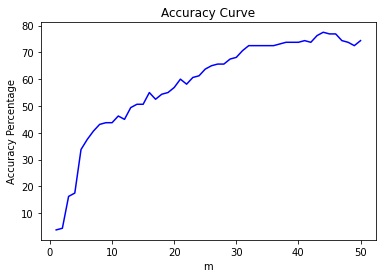

In [29]:
plt.plot(np.arange(1,51), accuracyCurve, color ="blue")  
plt.title("Accuracy Curve")  
plt.xlabel("m")  
plt.ylabel("Accuracy Percentage") 
plt.show()

In [27]:
# true labels
trueLabels2 = np.arange(0,160)
trueLabels2 = (trueLabels//4)
accuracyCurve2 = []

for m in range(1,6):

    # minimum distance
    min_dist = 999999999

    distances = [0]*q
    predictedLabels2 = [0]*q

    for i in range(Projected_Fisher_Test_Img.shape[1]):
        for j in range(FF.shape[1]):
            dist = mahalanobis_distance(Projected_Fisher_Test_Img[0:m,i],FF[0:m,j],FF[:,0:m])
            if(dist < min_dist):
                min_dist = dist
                label = j

        distances[i] = min_dist
        predictedLabels2[i] = (label//6) # each person testset contains 4 images
        min_dist = 99999999

    accuracy = accuracy_rate(trueLabels2,predictedLabels2)
    accuracyCurve2.append(accuracy)

<ipython-input-4-3a1cfdcad7e2>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  cov[z][y] = np.dot(X[:,y].T,X[:,z])/r


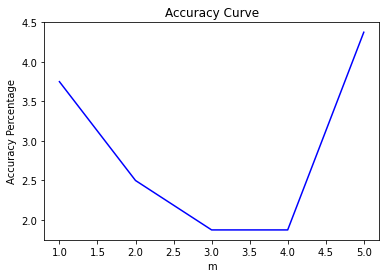

In [30]:
plt.plot(np.arange(1,6), accuracyCurve2, color ="blue")  
plt.title("Accuracy Curve")  
plt.xlabel("m")  
plt.ylabel("Accuracy Percentage") 
plt.show()